<a href="https://colab.research.google.com/github/NicolasDenier/Handwriting-recognition/blob/main/Handwriting_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
import pandas as pd 
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout, RandomRotation, RandomZoom, GaussianNoise

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [97]:
# Metadata: label and path of each image
characters_data_url = "drive/My Drive/Colab Notebooks/OCR-data/characters/"
characters = pd.read_csv(characters_data_url + "english.csv")
characters.head()

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0


(900, 1200, 3)


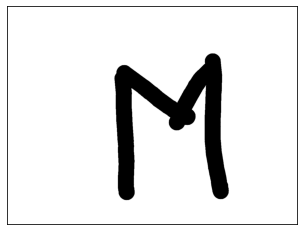

In [98]:
# Show a single image to have an idea of the data
img = image.imread(characters_data_url+characters['image'][1234])
print(img.shape)
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.imshow(img)
plt.show()

In [99]:
print(np.min(img), np.max(img))

0.0 1.0


In [223]:
# Number of images in a batch
batch_size = 64
# The desired image size
img_height = 90
img_width = 120
SEED=22

In [224]:
classes = characters['label'].unique() # list of classes
num_classes=len(characters['label'].unique()) # number of classes (10 diits + 26 lowercase + 26 uppercase = 62)
label_to_int = {classes[i]:i for i in range(num_classes)} # dict to get an unique id as int for each class
int_to_label = {value:key for key, value in label_to_int.items()} # dict to get back a string label from an int
labels = [label_to_int[l] for l in characters['label']] # list of labels as int

In [225]:
# Prepare the data stream batches (it avoids to overload the RAM)
train_ds = tf.keras.utils.image_dataset_from_directory(
    characters_data_url,
    labels = labels,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    color_mode = 'grayscale',
    seed=SEED,
    validation_split = 0.2,
    shuffle=True,
    subset = "training"
    )

# For some reason the labels are definitely shuffled and need to be redefined
labels = [label_to_int[l] for l in characters['label']]

val_ds = tf.keras.utils.image_dataset_from_directory(
    characters_data_url,
    labels = labels,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    color_mode = 'grayscale',
    seed=SEED,
    validation_split = 0.2,
    shuffle=True,
    subset = "validation"
    )


Found 3410 files belonging to 1 classes.
Using 2728 files for training.
Found 3410 files belonging to 1 classes.
Using 682 files for validation.


(64, 90, 120, 1)
(64,)


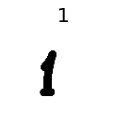

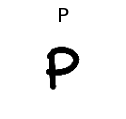

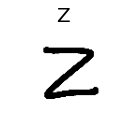

In [226]:
# Check that the labels are correct
def plot_char(image, title):
  plt.figure(figsize=(2, 2))
  plt.imshow(np.reshape(image,(img_height, img_width)), cmap="gray")
  plt.axis('off')
  plt.title(title, fontsize=20)
  plt.show()

for image, label in val_ds:
    print(image.shape)
    print(label.shape)
    for i in range(3):
      title=int_to_label[label.numpy()[i]]
      plot_char(image[i], title)
    break

In [227]:
# Better memory performances
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## First model

In [228]:
img_shape = (img_height, img_width, 1)

# define model
model1 = Sequential([
    Conv2D(16, padding='same', kernel_size=(3,3), activation='relu', input_shape=img_shape),
    MaxPooling2D(padding='same'),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [229]:
# compile
learning_rate = 1e-3
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

In [230]:
# fit
MODEL_NAME = 'base_model'
logs = {}
EPOCHS = 10
logs[MODEL_NAME] = model1.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
)

Epoch 1/10
43/43 [==============================] - 26s 139ms/step - loss: 17.5195 - accuracy: 0.0363 - val_loss: 4.0640 - val_accuracy: 0.0557
Epoch 2/10
43/43 [==============================] - 1s 16ms/step - loss: 3.2649 - accuracy: 0.2082 - val_loss: 2.6964 - val_accuracy: 0.3123
Epoch 3/10
43/43 [==============================] - 1s 15ms/step - loss: 1.7210 - accuracy: 0.5524 - val_loss: 2.1476 - val_accuracy: 0.4516
Epoch 4/10
43/43 [==============================] - 1s 15ms/step - loss: 0.9149 - accuracy: 0.7500 - val_loss: 2.0119 - val_accuracy: 0.4897
Epoch 5/10
43/43 [==============================] - 1s 15ms/step - loss: 0.4747 - accuracy: 0.8655 - val_loss: 2.3077 - val_accuracy: 0.4985
Epoch 6/10
43/43 [==============================] - 1s 15ms/step - loss: 0.2195 - accuracy: 0.9439 - val_loss: 2.3301 - val_accuracy: 0.5528
Epoch 7/10
43/43 [==============================] - 1s 15ms/step - loss: 0.1097 - accuracy: 0.9743 - val_loss: 2.4691 - val_accuracy: 0.5323
Epoch 8/10

In [92]:
def plot_graphs(history):
  for metric in ['accuracy', 'loss']:
    plt.figure(figsize=(8, 4))
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

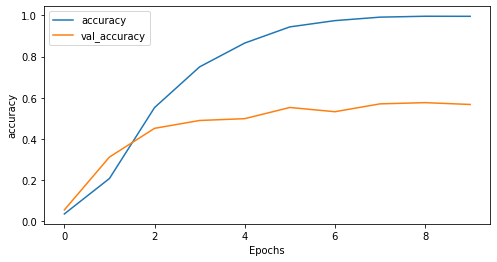

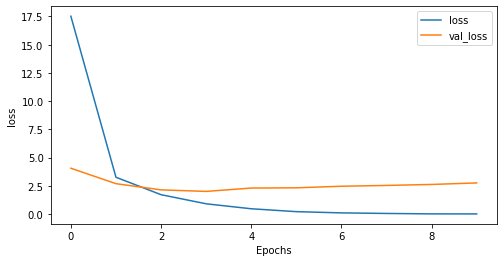

In [231]:
plot_graphs(logs[MODEL_NAME])

## More complex model
Adding 1 layer with more nodes, changing kernel size

In [289]:
def parallel_conv(filters, input_shape):
    input_shape = tf.keras.Input(shape=input_shape)

    conv_1 = Conv2D(filters, (7, 7), padding='same', activation='relu')(input_shape)
    conv_1 = MaxPooling2D(strides=(1, 1), padding='same')(conv_1)

    conv_2 = Conv2D(filters, (5, 5), padding='same', activation='relu')(input_shape)
    conv_2 = MaxPooling2D(strides=(1, 1), padding='same')(conv_2)

    conv_3 = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_shape)
    conv_3 = MaxPooling2D(strides=(1, 1), padding='same')(conv_3)

    merged = keras.layers.concatenate([conv_1, conv_2, conv_3], axis=1)
    out = MaxPooling2D()(merged)

    model = tf.keras.Model(input_shape, out)
    return model

model2 = Sequential([
    Conv2D(16, padding='same', kernel_size=(9,9), activation='relu', input_shape=img_shape),
    MaxPooling2D(padding='same'),
    #Conv2D(32, kernel_size=(5,5), activation='relu'),
    #MaxPooling2D(),
    parallel_conv(32, input_shape=(45,60,16)),
    parallel_conv(64, input_shape=( 67, 30, 32)),
    #Conv2D(64, kernel_size=(5,5), activation='relu'),
    #MaxPooling2D(),
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

model2.summary()

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_283 (Conv2D)         (None, 90, 120, 16)       1312      
                                                                 
 max_pooling2d_292 (MaxPooli  (None, 45, 60, 16)       0         
 ng2D)                                                           
                                                                 
 model_10 (Functional)       (None, 67, 30, 32)        42592     
                                                                 
 model_11 (Functional)       (None, 100, 15, 64)       170176    
                                                                 
 conv2d_290 (Conv2D)         (None, 98, 13, 128)       73856     
                                                                 
 max_pooling2d_301 (MaxPooli  (None, 49, 6, 128)       0         
 ng2D)                                               

In [290]:
# fit
MODEL_NAME = 'more_complex'

logs[MODEL_NAME] = model2.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
)

Epoch 1/10
43/43 [==============================] - 7s 114ms/step - loss: 28.4964 - accuracy: 0.0407 - val_loss: 3.8847 - val_accuracy: 0.1129
Epoch 2/10
43/43 [==============================] - 4s 84ms/step - loss: 3.0764 - accuracy: 0.2397 - val_loss: 2.2739 - val_accuracy: 0.4194
Epoch 3/10
43/43 [==============================] - 4s 84ms/step - loss: 1.6009 - accuracy: 0.5587 - val_loss: 1.4235 - val_accuracy: 0.6085
Epoch 4/10
43/43 [==============================] - 4s 84ms/step - loss: 0.8526 - accuracy: 0.7643 - val_loss: 1.3188 - val_accuracy: 0.6364
Epoch 5/10
43/43 [==============================] - 4s 85ms/step - loss: 0.4882 - accuracy: 0.8530 - val_loss: 1.2049 - val_accuracy: 0.6950
Epoch 6/10
43/43 [==============================] - 4s 85ms/step - loss: 0.2478 - accuracy: 0.9300 - val_loss: 1.1409 - val_accuracy: 0.7170
Epoch 7/10
43/43 [==============================] - 4s 85ms/step - loss: 0.1339 - accuracy: 0.9641 - val_loss: 1.2735 - val_accuracy: 0.6818
Epoch 8/10


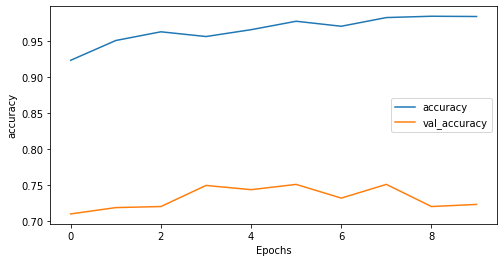

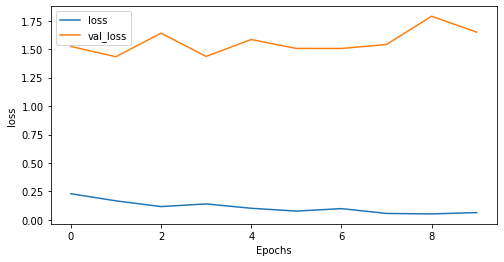

In [279]:
plot_graphs(logs[MODEL_NAME])

## Adding dropout
implies to train for more epochs to reach similar accuracy

In [235]:
model3 = Sequential([
    Conv2D(16, padding='same', kernel_size=(7,7), activation='relu', input_shape=img_shape),
    Dropout(0.5, seed=SEED),
    MaxPooling2D(padding='same'),
    Dropout(0.4, seed=SEED),
    Conv2D(32, kernel_size=(5,5), activation='relu'),
    Dropout(0.5, seed=SEED),
    MaxPooling2D(),
    Dropout(0.4, seed=SEED),
    Conv2D(64, kernel_size=(5,5), activation='relu'),
    MaxPooling2D(),
    Dropout(0.4, seed=SEED),
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])


model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

In [236]:
MODEL_NAME = 'dropout'
EPOCHS=40

logs[MODEL_NAME] = model3.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
)

Epoch 1/40
43/43 [==============================] - 2s 26ms/step - loss: 35.3499 - accuracy: 0.0213 - val_loss: 4.1249 - val_accuracy: 0.0220
Epoch 2/40
43/43 [==============================] - 1s 22ms/step - loss: 4.1758 - accuracy: 0.0180 - val_loss: 4.1214 - val_accuracy: 0.0176
Epoch 3/40
43/43 [==============================] - 1s 22ms/step - loss: 4.0831 - accuracy: 0.0374 - val_loss: 4.1100 - val_accuracy: 0.0455
Epoch 4/40
43/43 [==============================] - 1s 22ms/step - loss: 3.9827 - accuracy: 0.0414 - val_loss: 4.0769 - val_accuracy: 0.0455
Epoch 5/40
43/43 [==============================] - 1s 22ms/step - loss: 3.7802 - accuracy: 0.0641 - val_loss: 4.0173 - val_accuracy: 0.0938
Epoch 6/40
43/43 [==============================] - 1s 22ms/step - loss: 3.5537 - accuracy: 0.1133 - val_loss: 3.9245 - val_accuracy: 0.1554
Epoch 7/40
43/43 [==============================] - 1s 22ms/step - loss: 3.2833 - accuracy: 0.1617 - val_loss: 3.8363 - val_accuracy: 0.1994
Epoch 8/40
4

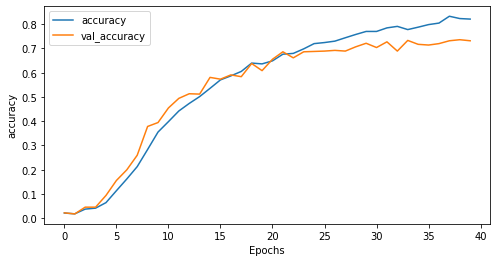

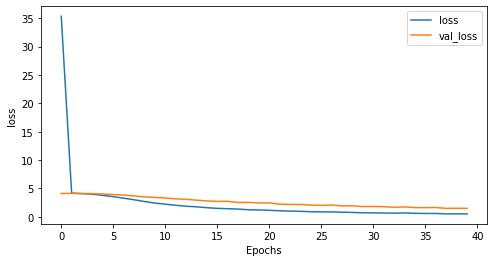

In [237]:
plot_graphs(logs[MODEL_NAME])

## Data augmentation

In [238]:
data_augmentation = Sequential(
  [
    GaussianNoise(0.3),
    RandomRotation((-0.1, 0.1), seed=SEED),
    RandomZoom(0.1, 0.1,  seed=SEED),
  ]
)

model4 = Sequential([
    data_augmentation,
    tf.keras.models.clone_model(model3)
])

model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )


In [239]:
MODEL_NAME = 'data_augmentation'

EPOCHS=50
logs[MODEL_NAME] = model4.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS
)

Epoch 1/50
43/43 [==============================] - 2s 27ms/step - loss: 37.7135 - accuracy: 0.0147 - val_loss: 4.1276 - val_accuracy: 0.0103
Epoch 2/50
43/43 [==============================] - 1s 24ms/step - loss: 4.1963 - accuracy: 0.0194 - val_loss: 4.1281 - val_accuracy: 0.0176
Epoch 3/50
43/43 [==============================] - 1s 24ms/step - loss: 4.1273 - accuracy: 0.0198 - val_loss: 4.1296 - val_accuracy: 0.0147
Epoch 4/50
43/43 [==============================] - 1s 23ms/step - loss: 4.1036 - accuracy: 0.0282 - val_loss: 4.1458 - val_accuracy: 0.0147
Epoch 5/50
43/43 [==============================] - 1s 23ms/step - loss: 4.0898 - accuracy: 0.0246 - val_loss: 4.1934 - val_accuracy: 0.0147
Epoch 6/50
43/43 [==============================] - 1s 23ms/step - loss: 4.0527 - accuracy: 0.0337 - val_loss: 4.2768 - val_accuracy: 0.0205
Epoch 7/50
43/43 [==============================] - 1s 23ms/step - loss: 3.9656 - accuracy: 0.0422 - val_loss: 4.5588 - val_accuracy: 0.0205
Epoch 8/50
4

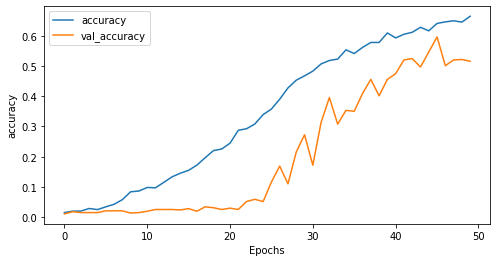

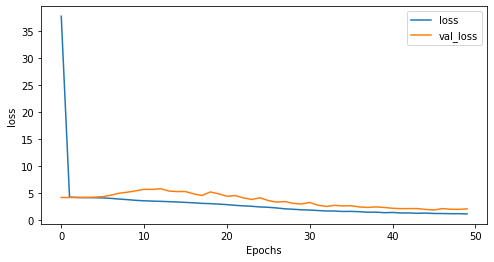

In [240]:
plot_graphs(logs[MODEL_NAME])

## Adjusting learning rate 
adding callbacks to adjust learning rate and do early stopping

In [218]:
# early stopping
cb_EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

# learning rate scheduler
def scheduler(epoch, lr):
  if epoch < 40:
    return lr
  else:
    return lr * tf.math.exp(-0.005*epoch)

cb_LRScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [222]:
model5=tf.keras.models.clone_model(model4)
MODEL_NAME = 'adjusted_learning_rate'

model5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

EPOCHS=80

logs[MODEL_NAME] = model5.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    callbacks=[cb_EarlyStopping, cb_LRScheduler]
)

Epoch 1/80
44/44 [==============================] - 2s 29ms/step - loss: 64.9371 - accuracy: 0.0154 - val_loss: 4.1274 - val_accuracy: 0.0220 - lr: 0.0010
Epoch 2/80
44/44 [==============================] - 1s 24ms/step - loss: 4.2781 - accuracy: 0.0165 - val_loss: 4.1269 - val_accuracy: 0.0132 - lr: 0.0010
Epoch 3/80
44/44 [==============================] - 1s 25ms/step - loss: 4.1869 - accuracy: 0.0158 - val_loss: 4.1277 - val_accuracy: 0.0161 - lr: 0.0010
Epoch 4/80
44/44 [==============================] - 1s 23ms/step - loss: 4.1511 - accuracy: 0.0191 - val_loss: 4.1275 - val_accuracy: 0.0161 - lr: 0.0010
Epoch 5/80
44/44 [==============================] - 1s 23ms/step - loss: 4.1396 - accuracy: 0.0235 - val_loss: 4.1283 - val_accuracy: 0.0191 - lr: 0.0010
Epoch 6/80
44/44 [==============================] - 1s 23ms/step - loss: 4.1231 - accuracy: 0.0205 - val_loss: 4.1277 - val_accuracy: 0.0205 - lr: 0.0010
Epoch 7/80
44/44 [==============================] - 1s 23ms/step - loss: 4.

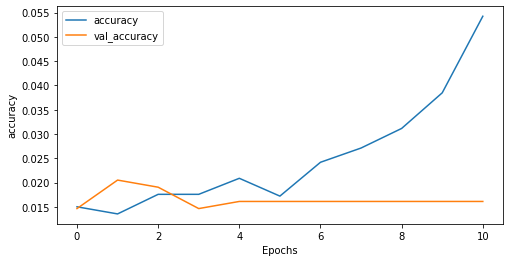

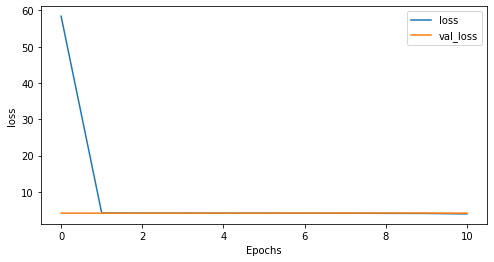

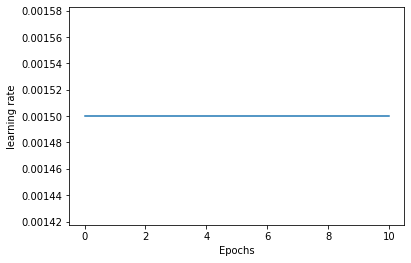

In [220]:
plot_graphs(logs[MODEL_NAME])

plt.plot(logs[MODEL_NAME].history['lr'])
plt.xlabel("Epochs")
plt.ylabel('learning rate')
plt.show()

In [ ]:
model5.save("model.h5")

Plot wrong predictions

11/11 [==============================] - 0s 7ms/step


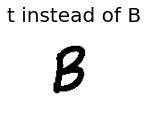

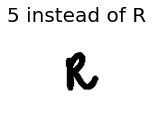

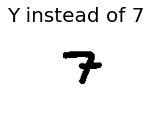

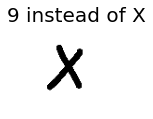

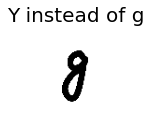

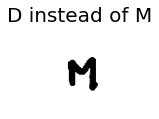

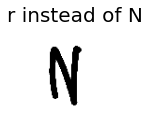

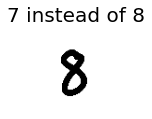

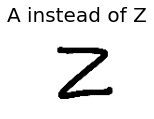

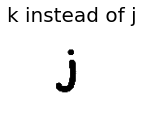

In [ ]:
predictions = model5.predict(val_ds)
i=0
for image, label in val_ds:
  if np.argmax(predictions[i]) != label[i]:
    title=int_to_label[np.argmax(predictions[i])] + " instead of " + int_to_label[label.numpy()[i]]
    plot_char(image[i], title)
  i+=1
